In [1]:
print('f')

f


In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

data_dir = './pj'
output_dir = './pj_split'
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Train, val 폴더 생성
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val'), exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(output_dir, 'train', cls), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val', cls), exist_ok=True)
    
    class_dir = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
    
    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'train', cls, img))
        
    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'val', cls, img))

print("Data splitting completed.")

Data splitting completed.


Epoch 0/9
train Loss: 0.9596 Acc: 0.6873 Recall: 0.6318
val Loss: 0.5968 Acc: 0.7969 Recall: 0.7815

Epoch 1/9
train Loss: 0.5717 Acc: 0.8152 Recall: 0.7761
val Loss: 0.6447 Acc: 0.8132 Recall: 0.7906

Epoch 2/9
train Loss: 0.4195 Acc: 0.8677 Recall: 0.8365
val Loss: 0.4072 Acc: 0.8764 Recall: 0.8391

Epoch 3/9
train Loss: 0.3209 Acc: 0.8982 Recall: 0.8745
val Loss: 0.4288 Acc: 0.8736 Recall: 0.8551

Epoch 4/9
train Loss: 0.2408 Acc: 0.9234 Recall: 0.9039
val Loss: 0.3462 Acc: 0.9015 Recall: 0.8824

Epoch 5/9
train Loss: 0.1867 Acc: 0.9393 Recall: 0.9239
val Loss: 0.3308 Acc: 0.9142 Recall: 0.8953

Epoch 6/9
train Loss: 0.1618 Acc: 0.9483 Recall: 0.9362
val Loss: 0.3474 Acc: 0.9089 Recall: 0.8769

Epoch 7/9
train Loss: 0.1280 Acc: 0.9569 Recall: 0.9471
val Loss: 0.4204 Acc: 0.8897 Recall: 0.8509

Epoch 8/9
train Loss: 0.1102 Acc: 0.9642 Recall: 0.9554
val Loss: 0.3861 Acc: 0.9057 Recall: 0.8740

Epoch 9/9
train Loss: 0.1037 Acc: 0.9671 Recall: 0.9600
val Loss: 0.3557 Acc: 0.9138 Recall

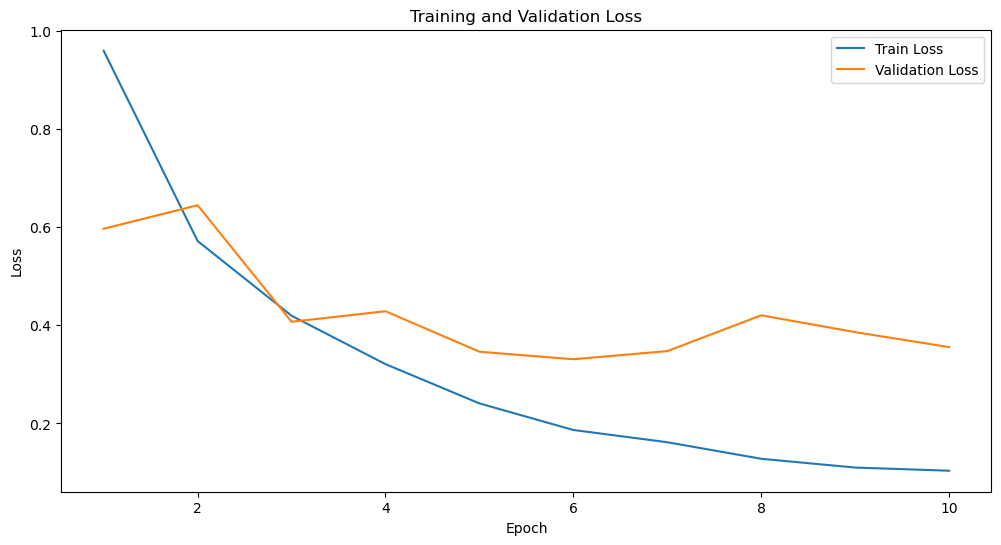

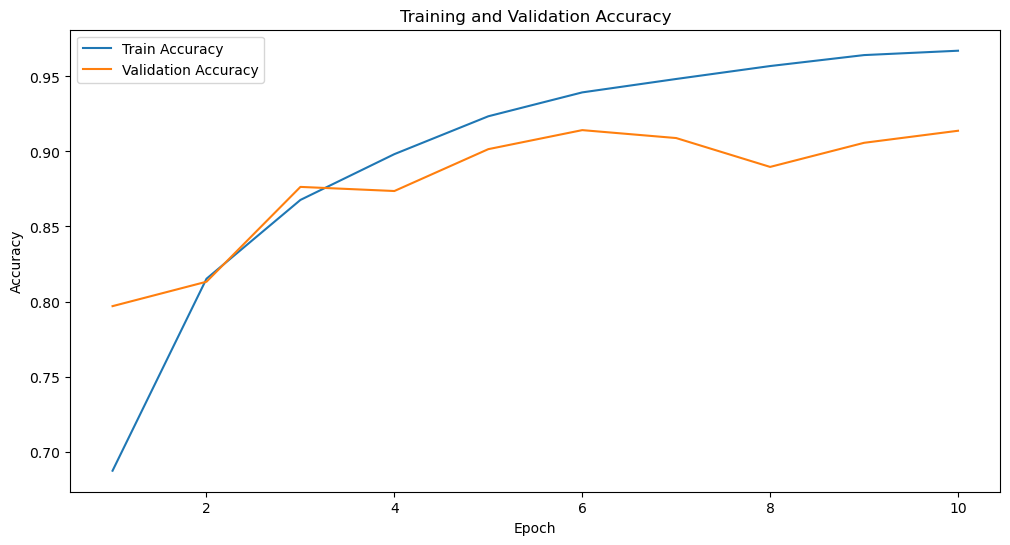

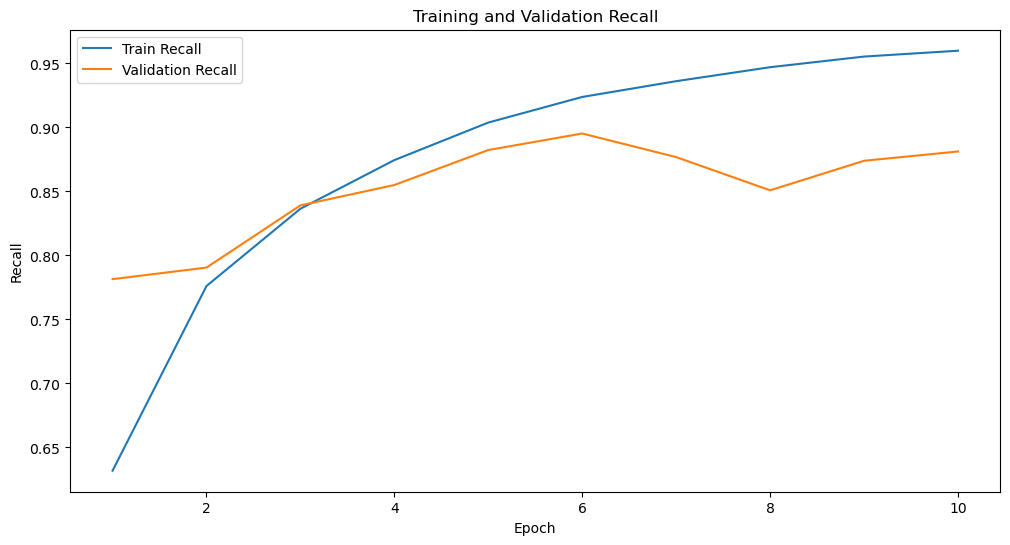

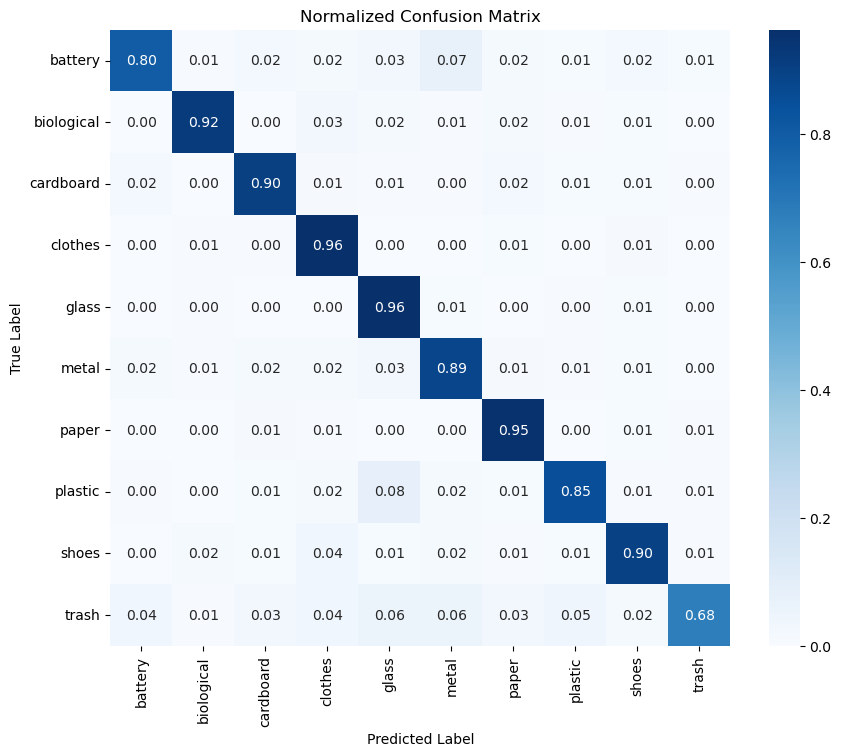

In [7]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns
import numpy as np

# 데이터 전처리
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './pj_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ResNet-18 모델 불러오기 및 수정
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

# 학습 및 평가 함수
def train_model(model, criterion, optimizer, start_epoch=0, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    train_recall_history = []
    val_recall_history = []
    
    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_str = f'Epoch {epoch}/{start_epoch + num_epochs - 1}'
        print(epoch_str)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # GPU 메모리 정리
                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_recall = recall_score(all_labels, all_preds, average='macro')
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
                train_recall_history.append(epoch_recall)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                val_recall_history.append(epoch_recall)
            
            log_str = f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Recall: {epoch_recall:.4f}'
            print(log_str)
        
        print()

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_recall_history, val_recall_history

# 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_recall_history, val_recall_history = train_model(model, criterion, optimizer, start_epoch=0, num_epochs=10)

# 모델 저장
torch.save(model.state_dict(), 'recycle_classification_model_resnet18.pth')

# 시각화
epochs = list(range(1, len(train_loss_history) + 1))

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_history, label='Train Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# 학습 및 검증 리콜 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_recall_history, label='Train Recall')
plt.plot(epochs, val_recall_history, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')
plt.show()

# 모델 평가 및 혼동 행렬 계산 함수
def evaluate_model_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 비율로 변환
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 혼동 행렬 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

# 클래스 이름 설정
class_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

# 검증 데이터셋에 대해 혼동 행렬 계산 및 시각화
evaluate_model_and_plot_confusion_matrix(model, dataloaders['val'], class_names)


Epoch 10/29
train Loss: 0.0824 Acc: 0.9749 Recall: 0.9680
val Loss: 0.3767 Acc: 0.9087 Recall: 0.8749

Epoch 11/29
train Loss: 0.0860 Acc: 0.9729 Recall: 0.9669
val Loss: 0.3820 Acc: 0.9013 Recall: 0.8757

Epoch 12/29
train Loss: 0.0655 Acc: 0.9782 Recall: 0.9730
val Loss: 0.3794 Acc: 0.9057 Recall: 0.8757

Epoch 13/29
train Loss: 0.0607 Acc: 0.9806 Recall: 0.9754
val Loss: 0.4699 Acc: 0.9017 Recall: 0.8764

Epoch 14/29
train Loss: 0.0747 Acc: 0.9774 Recall: 0.9732
val Loss: 0.3597 Acc: 0.9169 Recall: 0.9032

Epoch 15/29
train Loss: 0.0603 Acc: 0.9809 Recall: 0.9770
val Loss: 0.3823 Acc: 0.9068 Recall: 0.8849

Epoch 16/29
train Loss: 0.0512 Acc: 0.9841 Recall: 0.9801
val Loss: 0.4168 Acc: 0.9104 Recall: 0.8855

Epoch 17/29
train Loss: 0.0555 Acc: 0.9837 Recall: 0.9801
val Loss: 0.3969 Acc: 0.9079 Recall: 0.8860

Epoch 18/29
train Loss: 0.0427 Acc: 0.9865 Recall: 0.9843
val Loss: 0.4297 Acc: 0.9034 Recall: 0.8785

Epoch 19/29
train Loss: 0.0512 Acc: 0.9843 Recall: 0.9813
val Loss: 0.459

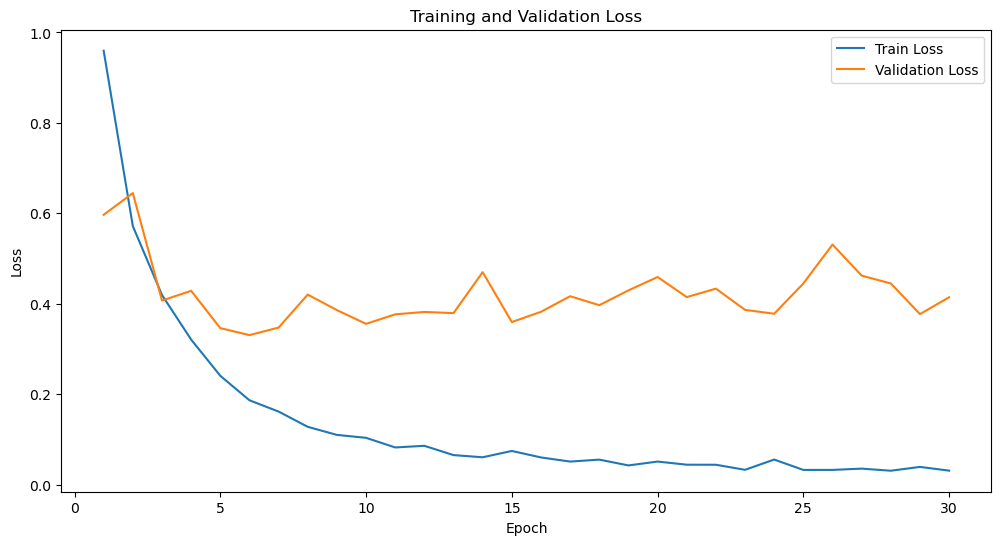

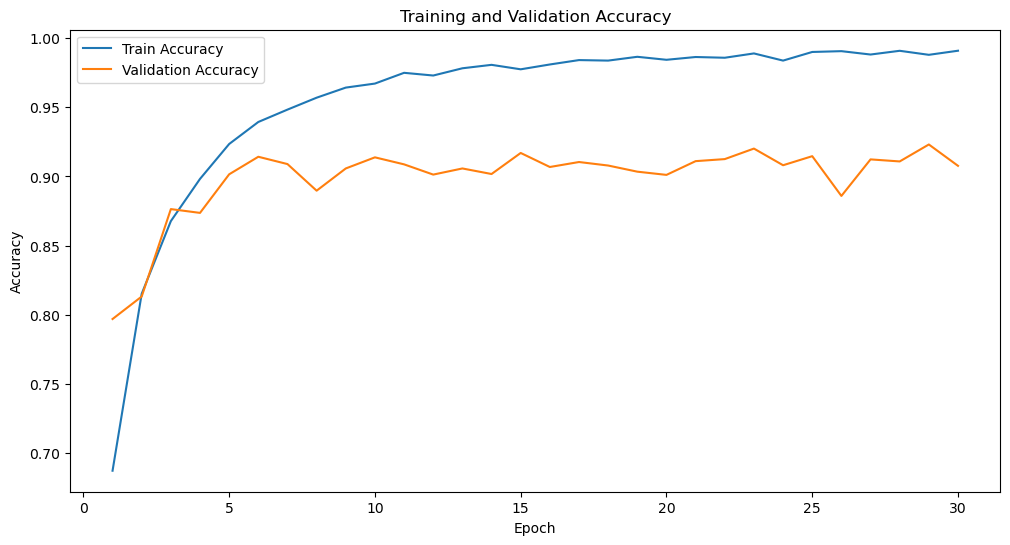

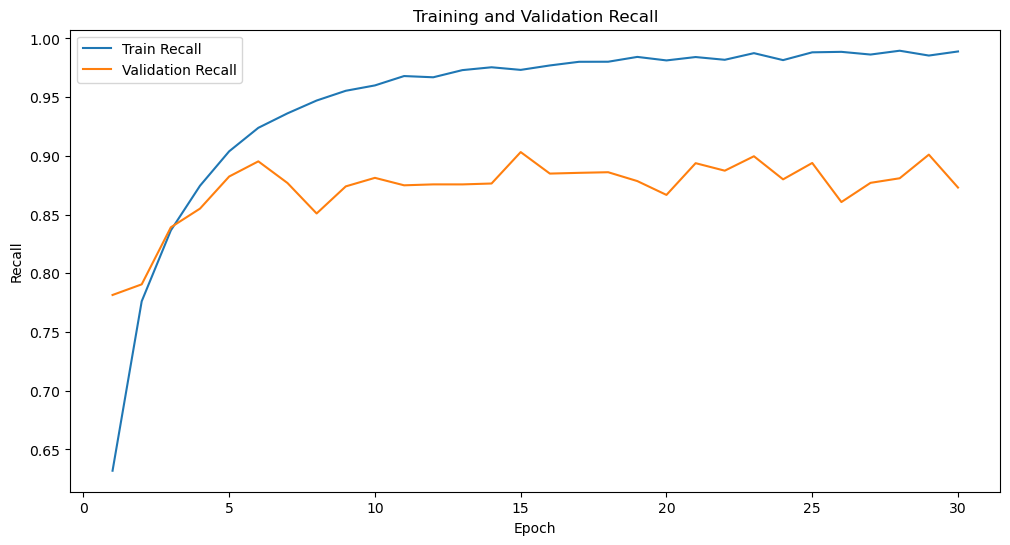

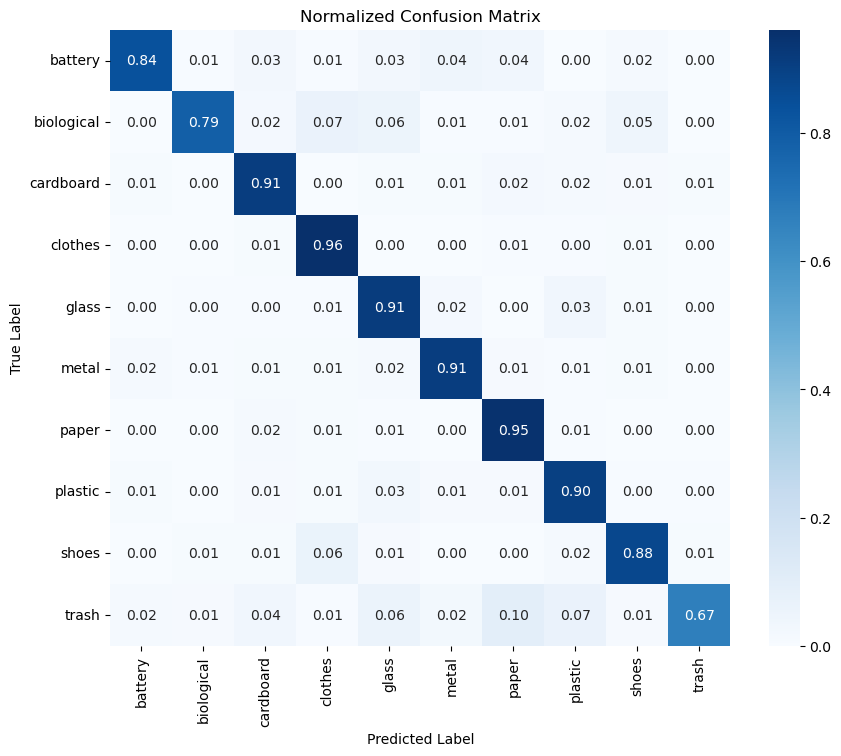

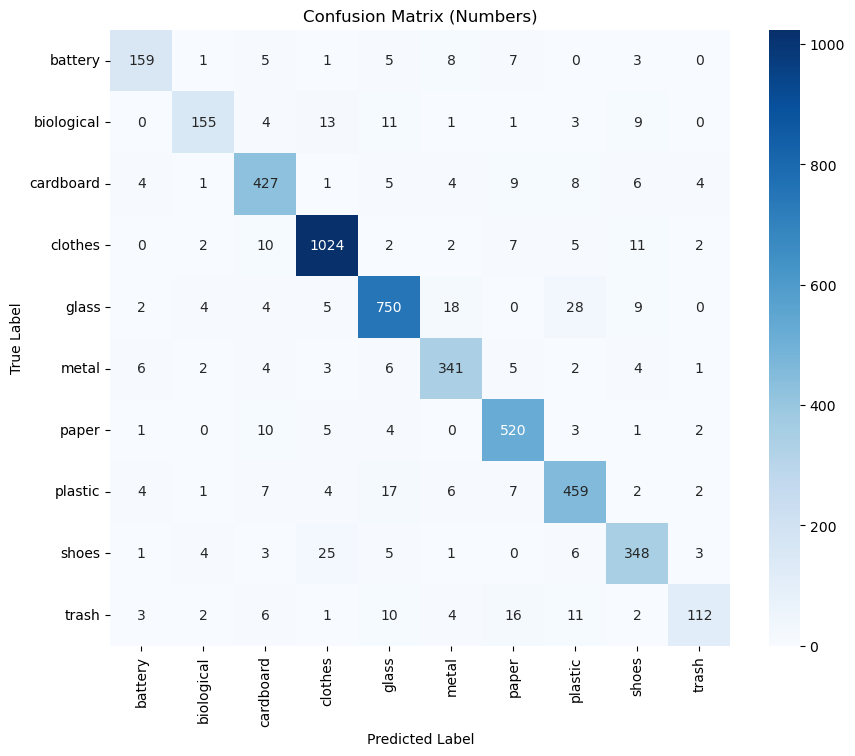

In [11]:
# 기존 모델 상태 불러오기
model.load_state_dict(torch.load('recycle_classification_model_resnet18.pth'))

# 추가 학습 수행
additional_model, additional_train_loss, additional_val_loss, additional_train_acc, additional_val_acc, additional_train_recall, additional_val_recall = train_model(model, criterion, optimizer, start_epoch=10, num_epochs=20)

# 기존 기록에 추가 학습 기록을 병합
train_loss_history.extend(additional_train_loss)
val_loss_history.extend(additional_val_loss)
train_acc_history.extend(additional_train_acc)
val_acc_history.extend(additional_val_acc)
train_recall_history.extend(additional_train_recall)
val_recall_history.extend(additional_val_recall)

# 모델 저장 (추가 학습 후)
torch.save(model.state_dict(), 'recycle_classification_model_resnet18_further.pth')

# 시각화 업데이트
epochs = list(range(1, len(train_loss_history) + 1))

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_history, label='Train Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# 학습 및 검증 리콜 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_recall_history, label='Train Recall')
plt.plot(epochs, val_recall_history, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')
plt.show()

# 혼동 행렬 시각화 업데이트
def evaluate_model_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 비율로 변환
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 혼동 행렬 시각화 - 비율
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
    # 혼동 행렬 시각화 - 숫자
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Numbers)')
    plt.show()

# 검증 데이터셋에 대해 혼동 행렬 계산 및 시각화
evaluate_model_and_plot_confusion_matrix(model, dataloaders['val'], class_names)
